<a href="https://colab.research.google.com/github/minthammock-development/kaggle_competitions/blob/main/hotel-id-to-combat-human-trafficking-2021-fgvc8/Hotel_ID_to_combat_human_trafficking_2021_fgvc8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Overview
This notebook will cover the image processing and model creation for the Hotel id to combat human trafficknig 2021 competition. Here's a general overview of the workflow.

## Basic Data Overview

## EDA

## Establish Model Baseline

## Classical ML Models

## Neural Networks



# Basic Data Overview

First thing's first. Let go ahead and load in the data and checkout summary statistics as well as some individual samples to understand what we're dealing with. 

In [ ]:
!unzip -q ./drive/MyDrive/data_sets/hotel-id-2021-fgvc8.zip

In [50]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from sklearn.dummy import DummyClassifier
from sklearn.utils import class_weight
import plotly.express as px
import plotly.graph_objects as go

In [86]:
# this cell checks our images for forematting corruption and removes them
num_skipped = 0
for folder_name in os.listdir("./train_images",):
    folder_path = os.path.join("./train_images", folder_name)
    for f in os.listdir(folder_path):
      f_path = os.path.join(folder_path,f)
      try:
          fobj = open(f_path, "rb")
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      finally:
          fobj.close()

      if not is_jfif:
          num_skipped += 1
          # Delete corrupted image
          os.remove(f_path)

print("Deleted %d images" % num_skipped)

Deleted 0 images


Now let's get some imports going

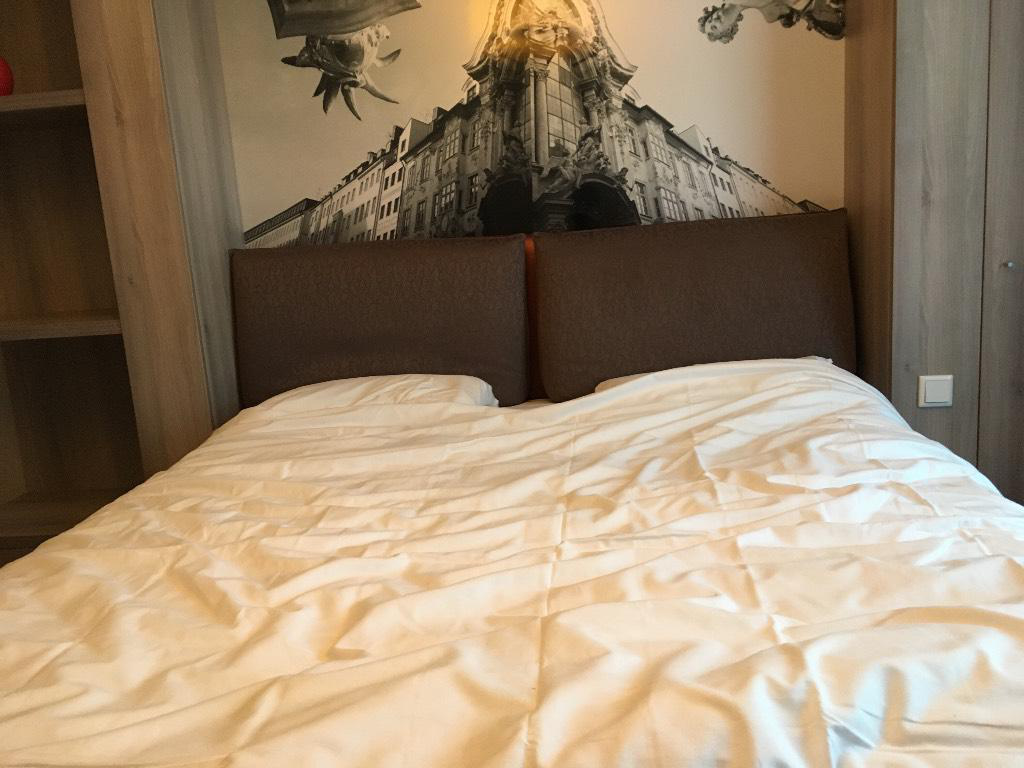

In [3]:
testImage1 = '/content/train_images/10/8272fa951d786995.jpg'
testImage2 = '/content/train_images/10/86709f39449cb367.jpg'
preprocessing.image.load_img(testImage1)

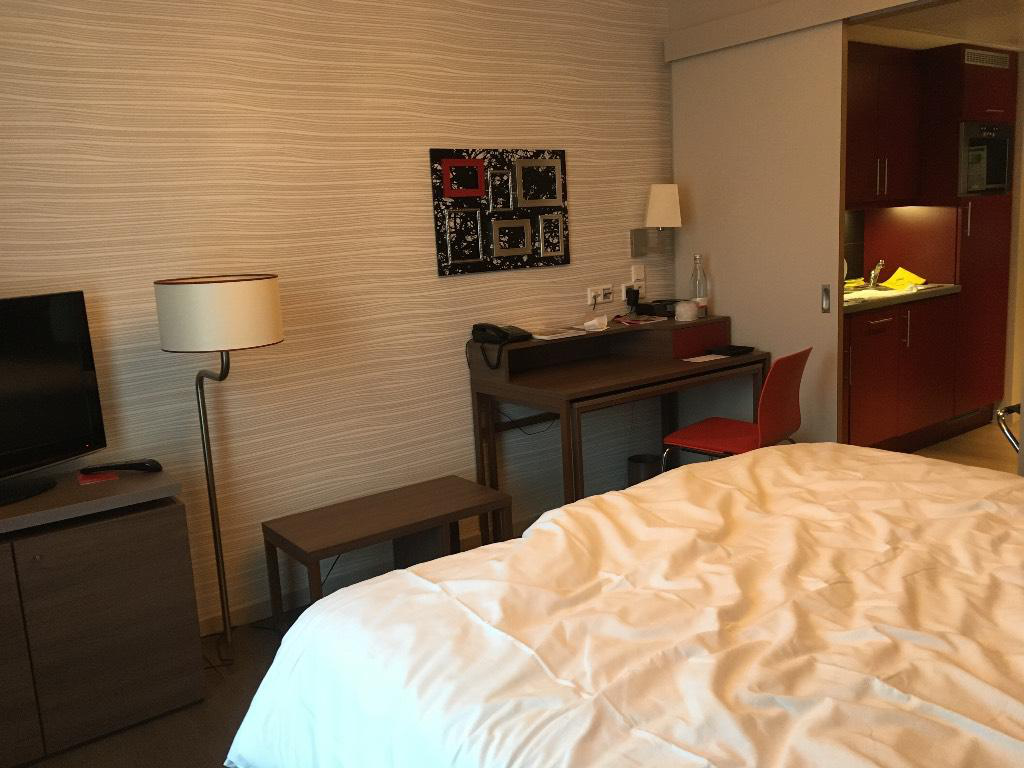

In [4]:
preprocessing.image.load_img(testImage2)

It looks like images are various angles of the room. This adds an extra challenge as images of the same class are going to be vastly different. Moreover, because people images focus on different angles of the same room, there likely won't be many samples that focus on the same features. My first throughts are as follows:

* Any model we design should be focused on picking up general but characteristic features of the hotel rooms. This could be things like wallpaper or carpet with specific designs. As such elements are more the background features and represent vague concepts, shallower NNs will likely be the way to go.

## Summary Stats


Moving on we'll go ahead and load in the data and see how many we're dealing with

In [58]:
trainGenerator = preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
    validation_split = .2,
)

loadedTrainImages = trainGenerator.flow_from_directory(
    'train_images/', 
    # batch_size=64,
    target_size = (256,256),
    batch_size = 97554,
    shuffle = False,
    subset = 'validation',
    
)

Found 8927 images belonging to 84 classes.


In [74]:
np.unique(loadedTrainImages.classes)

array([ 0,  1,  2,  3,  4,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54,
       55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71,
       72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83], dtype=int32)

In [61]:
generatorLength = len(loadedTrainImages)

We have successfully loaded in the images and onehot encodded target column. From the print out, there are 97554 images total in 88 different classes. Our dataset is large so the 88 classes isn't immediately worrying. Let's checkout what the class imbalance looks like for these 88.  

In [62]:
classCounts = {}
for i in range(0,87):
  for path,dir,files in os.walk(f'/content/train_images/{i}'):
    classCounts[i] = len(files)

In [63]:
fig = px.bar(
    x = list(classCounts.keys()), 
    y = list(classCounts.values()),
    title = 'Samples Per Class Label',
    labels = {
        'X':'Class Label',
        'y':'Sample Count'
    }
)
fig.show()

The anwser is abysmal class imbalance! No amount of image augmentation is going to get the super minority classes anywhere near the majority classes. The best approach is likely going to be some sort of undersampling of the majority combined with oversampling of the minority. Personally, I don't find this approach likely to yield good results but we'll see as we go through. For posterity sake, a dry run with no data alterations is still in order,

In [9]:
np.unique(loadedTrainImages.classes)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83],
      dtype=int32)

In [10]:
classWeights = class_weight.compute_class_weight('balanced', np.unique(loadedTrainImages.classes), loadedTrainImages.labels)
classWeights

array([5.26961562e-02, 8.60250950e-01, 8.89642857e+01, 4.32215153e+00,
       4.10604396e+01, 1.33446429e+02, 1.33446429e+02, 2.13514286e+01,
       1.33446429e+02, 2.74510524e-01, 3.95396825e+01, 3.81275510e+01,
       5.73963134e+00, 1.61753247e+01, 2.66892857e+01, 1.72188940e+01,
       3.44377880e+01, 2.42629870e+01, 4.85259740e+01, 1.21314935e+01,
       1.97771661e-01, 9.79423329e+00, 2.73736264e+01, 2.66892857e+01,
       2.17871720e+01, 4.41145218e+00, 4.85259740e+00, 1.28623064e+01,
       1.72188940e+01, 2.56627747e+00, 6.17093311e+00, 2.23762613e-01,
       1.27091837e+01, 6.79981802e+00, 9.20320197e+00, 2.55399863e+00,
       4.30472350e+00, 5.61879699e+00, 1.03647712e+01, 1.44266409e+01,
       9.53188776e+00, 1.68705978e-01, 1.76458087e+00, 3.22529132e+00,
       1.93050891e+00, 1.87952716e+00, 4.83063995e+00, 4.15397443e+00,
       1.33446429e+02, 4.83063995e+00, 8.21208791e+01, 9.12454212e+00,
       1.30877949e-01, 7.36256158e+00, 3.29497354e+00, 7.77546561e-01,
      

# Baseline Model

We are going to set the baseline by using an sklearn dummy classifier which will guess the each class according to it's class weight.

In [146]:
kerasClassWeights = {i:classWeights[i] for i in range(len(np.unique(loadedTrainImages.classes)))}
# kerasClassWeights

In [147]:
df = pd.DataFrame({"filename":images,"class":labels})   
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89675 entries, 0 to 89674
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  89675 non-null  object
 1   class     89675 non-null  object
dtypes: object(2)
memory usage: 1.4+ MB


In [153]:
dfSample = df.sample(
    n = 20000, 
)

# check to make sure the sampling was stratified
diff = (dfSample["class"].value_counts(normalize=True) - df["class"].value_counts(normalize=True)).sum()
print(f'The total diff between the original class proportionality: {diff}')

The total diff between the original class proportionality: 8.92110398661764e-05


In [154]:
train = trainGenerator.flow_from_dataframe(
    dataframe = dfSample,
    directory = 'train_images/', 
    batch_size=64,
    target_size = (256,256),
    shuffle = False,
    subset = 'training',
)
val = trainGenerator.flow_from_dataframe(
    dataframe = dfSample,
    directory = 'train_images/', 
    batch_size=64,
    target_size = (256,256),
    shuffle = False,
    subset = 'validation'
)
np.unique(train.labels)

Found 18000 validated image filenames belonging to 83 classes.
Found 2000 validated image filenames belonging to 83 classes.


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82])

In [155]:
classesNum = len(loadedTrainImages.classes)
# We will be using the keras functional API for building models. 

# define the input layer
baselineModelInputs = layers.Input(shape = (256,256,3), name = 'input_layer')

x1 = layers.Flatten()(baselineModelInputs)

# define the first layer
x2 = layers.Dense(64, activation = 'sigmoid')(x1)
x3 = layers.Dense(64, activation = 'sigmoid')(x2)
# define the ourput layer
baselineModelOutput = layers.Dense(84, activation = 'sigmoid')(x3)

# Create an instance of the keras.Model class with the input and outputs above
baselineModel = models.Model(inputs=baselineModelInputs, outputs = baselineModelOutput, name = 'baseline_model')

#compile the model
baselineModel.compile(
    optimizer = 'sgd',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [156]:
baselineModel.summary()

Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 256, 256, 3)]     0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 196608)            0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dense_33 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_34 (Dense)             (None, 84)                5460      
Total params: 12,592,596
Trainable params: 12,592,596
Non-trainable params: 0
_________________________________________________________________


In [157]:
# We fit the model, throwing in some basic parameters that will be tuned later. 
baselineHistory = baselineModel.fit(
    train,
    validation_data = val,
    batch_size=64,
    epochs=5,
    class_weight = kerasClassWeights,
#     callbacks=[baselineEarlyStop, baselineModelCheckpoint]  
)

Epoch 1/5


InvalidArgumentError: ignored

In [ ]:
def get_proportions:
  

In [10]:
loadedTrainImages

In [ ]:
dummyModel = DummyClassifier(strategy='stratified')
dummyModel.fit(loadedTrainImages, loadedTrainImages.labels, sample_weight=classWeights)

In [ ]:
dummyModel